# Debugging Your Homework

This notebook helps you interactively debug homework 5.

In [1]:
# Enable autoreload to make debugging easier

%load_ext autoreload
%autoreload 2

In [ ]:
# Make sure the homework is installed as a package in the "editing" mode:

! pip install -e ..

In [2]:
# Then, load all the necessary packages
# Note that there's warning from Wswiglal-redir-stdio that we will filter out

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

from phys305_hw5 import *
import numpy as np
import matplotlib.pyplot as plt

from bilby.core.prior import Uniform, PowerLaw

## Getting the data: GW150914

Just like the tutorial, we'll analyse GW150914 in this homework.
Our first task is to use `Interferometer()` to load up some data.

In [3]:
time_of_event = 1126259462.4

L1 = Interferometer('L1', time_of_event)
H1 = Interferometer('H1', time_of_event)

If your `Interferometer()` is implemented correctly, the following visualizations should work.

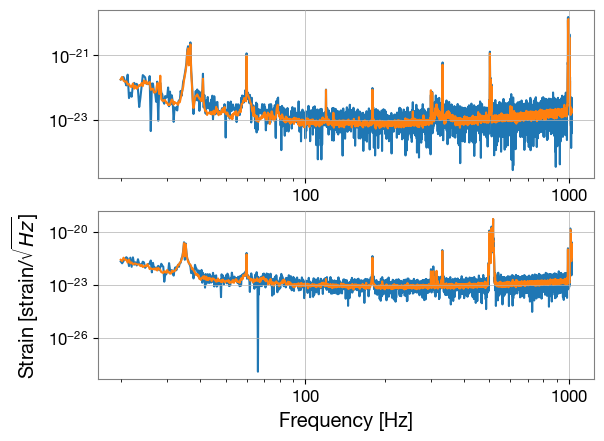

In [4]:
fig, (ax0, ax1) = plt.subplots(2,1)

idxs = H1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax0.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]))
ax0.loglog(H1.power_spectral_density.frequency_array[idxs],
          H1.power_spectral_density.asd_array[idxs])

idxs = L1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax1.loglog(L1.strain_data.frequency_array[idxs],
          np.abs(L1.strain_data.frequency_domain_strain[idxs]))
ax1.loglog(L1.power_spectral_density.frequency_array[idxs],
          L1.power_spectral_density.asd_array[idxs])

ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
plt.show()

We combine the two interferometers into a list for later use:

In [5]:
interferometers = [H1, L1]

## Create a Prior

Here, we create a prior fixing everything except the chirp mass, mass ratio, phase, geocent_time, and luminosity distance parameters.
We narrow the domain of `phase`, `geocent_time`, and `luminosity_distance` based on the fitted values from the tutorial.
This allows us to simplify this homework.

In [6]:
prior = bilby.core.prior.PriorDict()

prior['chirp_mass']   = Uniform(name='chirp_mass',   minimum=28.0,maximum=32)
prior['mass_ratio']   = Uniform(name='mass_ratio',   minimum=0.5, maximum=1)
prior['phase']        = Uniform(name="phase",        minimum=4.54-0.2,   maximum=4.54+0.2)
prior['geocent_time'] = Uniform(name="geocent_time", minimum=time_of_event-0.01, maximum=time_of_event+0.01)
prior['a_1']          =  0.0
prior['a_2']          =  0.0
prior['tilt_1']       =  0.0
prior['tilt_2']       =  0.0
prior['phi_12']       =  0.0
prior['phi_jl']       =  0.0
prior['dec']          =  -1.2232
prior['ra']           =  2.19432
prior['theta_jn']     =  1.89694
prior['psi']          =  0.532268
prior['luminosity_distance'] = PowerLaw(alpha=2, name='luminosity_distance', minimum=277, maximum=320, unit='Mpc', latex_label='$d_L$')

The above values will be useful for homework assignment `a5.py`.

We can now use `prior` to sample and compute a probability.

In [7]:
sample = prior.sample()
print(sample)
print(prior.ln_prob(sample))

{'chirp_mass': 31.39611646933602, 'mass_ratio': 0.9905156473435628, 'phase': 4.72298152430555, 'geocent_time': 1126259462.398432, 'a_1': 0.0, 'a_2': 0.0, 'tilt_1': 0.0, 'tilt_2': 0.0, 'phi_12': 0.0, 'phi_jl': 0.0, 'dec': -1.2232, 'ra': 2.19432, 'theta_jn': 1.89694, 'psi': 0.532268, 'luminosity_distance': 308.32389392535123}
7098.2641303378805


## Waveform Generator

Next, we use `WaveformGenerator(duration, sampling_frequency, start_time)` to create a waveform generator.
Note that, because the parameters `duration`, `sampling_frequency`, `start_time` are the same for both interferometers, we only need to create one waveform generator.

In [8]:
print(
    L1.duration           == H1.duration,
    L1.sampling_frequency == H1.sampling_frequency,
    L1.start_time         == H1.start_time,
)

True True True


In [9]:
waveform_generator = WaveformGenerator(L1.duration, L1.sampling_frequency, L1.start_time)

10:35 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


If your `WaveformGenerator()` is implemented correctly, the following plot should work.

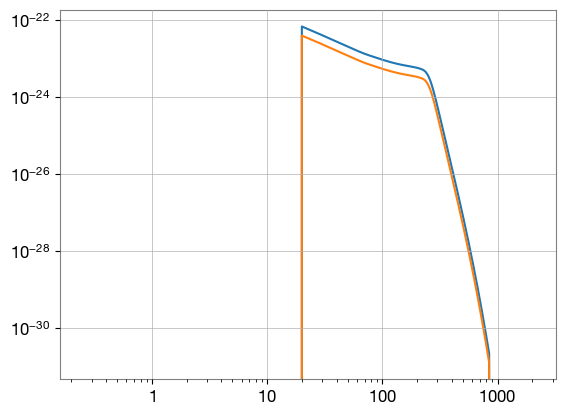

In [10]:
waveforms = waveform_generator.frequency_domain_strain(sample)

plt.loglog(waveform_generator.frequency_array, abs(waveforms['plus']))
plt.loglog(waveform_generator.frequency_array, abs(waveforms['cross']))

One may update the parameters in `sample` to generate a different waveform.

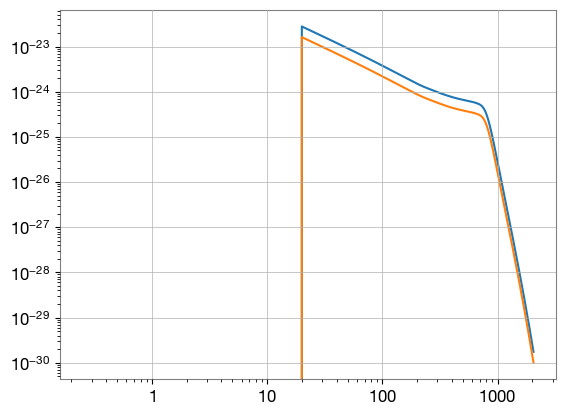

In [11]:
sample['chirp_mass'] = 10
waveforms = waveform_generator.frequency_domain_strain(sample)

plt.loglog(waveform_generator.frequency_array, abs(waveforms['plus']))
plt.loglog(waveform_generator.frequency_array, abs(waveforms['cross']))

## Create a likelihood

For Bayesian inference, we need to evaluate the likelihood.

In [12]:
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers, waveform_generator, priors=prior,
    time_marginalization=True, phase_marginalization=True, distance_marginalization=True)

10:35 bilby INFO    : Loaded distance marginalisation lookup table from .distance_marginalization_lookup.npz.


We can now compute `log_likelihood()` for different `parameters`.

In [13]:
for _ in range(10):
    likelihood.parameters = prior.sample()
    print(likelihood.log_likelihood())

-8273.801531026953
-8240.68666562522
-8276.195601128775
-8306.589779043878
-8247.244657296587
-8253.47288229925
-8245.335319943339
-8242.652352425072
-8242.03013835988
-8279.053528731903


## Run the analysis

Now that the prior is set-up and the likelihood is set-up (with the data and the signal mode), we can run our own MCMC sampler in `a3.py` to get the posterior result.

In [14]:
samples = mcmc_sampler(likelihood, prior, [0.1, 0.01])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 119.53it/s]

Efficiency: 0.1941747572815534


## Looking at the outputs

We can now use `a4.py` to print out statistics information and create a corner plot. 

median(chirp_mass) = 30.79571475229217 with a 90% C.I = 28.38366883177621 -> 31.85760634390306
median(mass_ratio) = 0.8897064896201902 with a 90% C.I = 0.6342489722166487 -> 0.9906377703305331


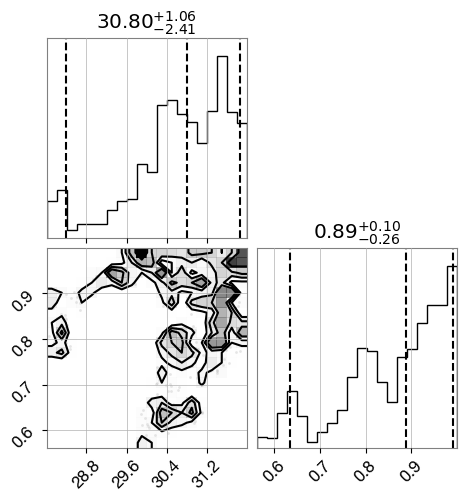

In [15]:
stat(samples, 'corner.png')